<center><b><font size=10>Data Mining - Project</font></b></center>
<center><b><font color='red' size=5>Forecasting Public Transportation Demand</font></b></center>

---
- ### An Introduction To The Project. "Background"
    * #### Forecasting transportation demand is important for multiple purposes such as staffing, planning, and inventory control. The public transportation system in Santiago de Chile has gone through a major effort of reconstruction. In this context, a business intelligence competition took place in October 2006, which focused on forecasting demand for public transportation. This case is based on the competition, with some modifications.
- ### Problem Description.
    * #### A public transportation company is expecting an increase in demand for its services and is planning to acquire new buses and to extend its terminals. These investments require a reliable forecast of future demand. To create such forecasts, one can use data on historic demand. The company’s data warehouse has data on each 15-minute interval between 6:30 and 22:00, on the number of passengers arriving at the terminal. As a forecasting consultant, you have been asked to create a forecasting method that can generate forecasts for the number of passengers arriving at the terminal.
    
- ### Available Data.
    * #### Part of the historic information is available in the file bicup2006.csv. The file contains the historic information with known demand for a 3-week period, separated into 15-minute intervals, and dates and times for a future 3-day period (DEMAND = NaN), for which forecasts should be generated (as part of the 2006 competition).

---
- ## What Is The Expected Content Of This Project?
    * #### We will mainly create a model/method that produces accurate forecasts.
---
- ## Table Of Contents:
    1. #### Importing Necessary Packages. [Go to T.1](#T.1)
    2. #### Perform Necessary Steps Before Initialize The Model. [Go to T.2](#T.2)
    3. #### Name of the method/combination of methods. [Go to T.3](#T.3)
    4. #### A brief description of the method/combination. [Go to T.4](#T.4)
    5. #### All estimated equations associated with constructing forecasts from this method. [Go to T.5](#T.5)
    6. #### The MAPE and MAE for the training period and the validation period. [Go to T.6](#T.6)
    7. ####  Forecasts for the future period (March 22–24), in 15-minute bins. [Go to T.7](#T.7)
    8. #### A single chart showing the fit of the final version of the model to the entire period (including training, validation, and future). Note that this model should be fitted using the combined training plus validation data. [Go to T.8](#T.8)
    9. #### Discuss the limitations and challenges encountered during the forecasting process and propose potential `Additional` [Go to T.9](#T.9)
    10. #### Explain how your forecasting method can be applied to other public transportation systems and the potential benefits it can provide `Additional` [Go to T.10](#T.10)

---
<a id="T.1"></a>
### Importing Necessary Packages:
- #### We May Need Some Of The Following Packages, And Modules: 
    * ##### Numpy.
    * ##### Pandas.
    * ##### Seaborn, MatplotLib.
    * ##### statsmodels.
    * ##### Sk-Learn "Science Kit Learn".

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

---
<a id="T.2"></a>
### Perform Necessary Steps Before Initialize The Model:
- #### In This Part, We Will:
    * ##### Read the data.
    * ##### Get the future data, which have null values as mentioned about the data previously.
    * ##### Split our known values data into training and validation sets.
    * ##### Have a look at the time series plots of our validation and training data.
    * ##### Plot `ACF` graph, to gain insights about the parameters for the model we are going to use.

In [2]:
# Load the dataset
data = pd.read_csv('C:\\Users\\Ameer\\Desktop\\DSAI\\Term 4\\Data Mining\\Datasets\\dmba-datasets\\dmba\\bicup2006.csv')
data_copy = data.copy()
data.head()

,DATE,TIME,DEMAND
0,1-Mar-05,6:30,1.0
1,1-Mar-05,6:45,2.0
2,1-Mar-05,7:00,4.0
3,1-Mar-05,7:15,0.0
4,1-Mar-05,7:30,10.0


In [3]:
future_set = data[data['DEMAND'].isna()]

In [4]:
# Convert the 'DATE' and 'TIME' columns in the copied data to a datetime format
data_copy['DATE_TIME'] = pd.to_datetime(data_copy['DATE'] + ' ' + data_copy['TIME'])
training_set_copy = data_copy.iloc[:882, :]
validation_set_copy = data_copy.iloc[882:future_set.index[0], :]

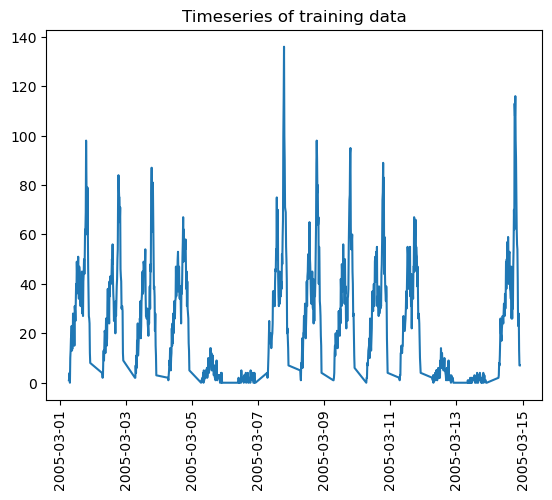

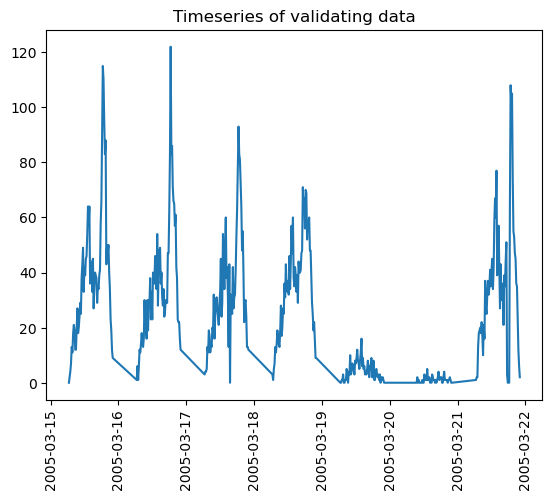

In [5]:
plt.plot(training_set_copy['DATE_TIME'], training_set_copy['DEMAND'])
plt.title('Timeseries of training data')
plt.xticks(rotation=90)
plt.show()

plt.plot(validation_set_copy['DATE_TIME'], validation_set_copy['DEMAND'])
plt.title('Timeseries of validating data')
plt.xticks(rotation=90)
plt.show()

In [6]:
# Split the data into training and validation periods
training_set = data.iloc[:882, :]
validation_set = data.iloc[882:future_set.index[0], :]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1512 non-null   object 
 1   TIME    1512 non-null   object 
 2   DEMAND  1323 non-null   float64
dtypes: float64(1), object(2)
memory usage: 35.6+ KB


In [8]:
data['DATE'] = pd.to_datetime(data['DATE'])
data['TIME'] = pd.to_datetime(data['TIME'], format='%H:%M').dt.time

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1512 non-null   datetime64[ns]
 1   TIME    1512 non-null   object        
 2   DEMAND  1323 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 35.6+ KB


In [10]:
combined_set = pd.concat([training_set, validation_set])
future_set = data[data['DEMAND'].isna()]
training_data = combined_set['DEMAND'].values

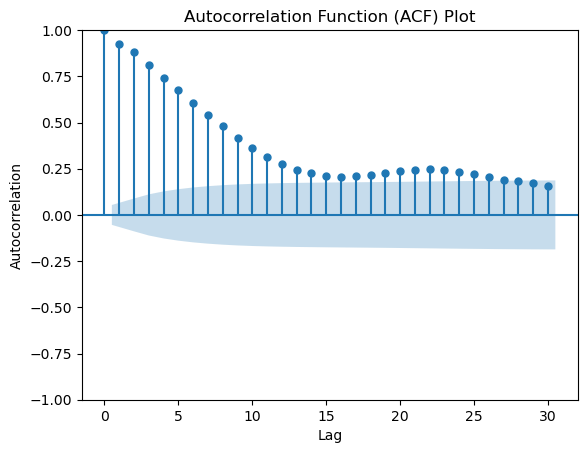

In [11]:
# ACF plot
plot_acf(combined_set['DEMAND'], lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

---
<a id="T.3"></a>
<a id="T.4"></a>
- ### Name of the method/combination of methods, for that we are going to:
    * ##### Use `SARIMAX` model.
- ### A brief description of the method/combination, for that:
    * ##### The `SARIMAX` model is an extension of the `ARIMA` model that takes into account the seasonal component in time series data. It combines the concepts of autoregressive (AR), integrated (I), and moving average (MA) models to capture the patterns and dependencies in the data. The seasonal component is incorporated by including additional seasonal AR, MA, and differencing terms. The model is capable of capturing both the short-term dynamics and the long-term trends in the data.

In [12]:
sarima_model = SARIMAX(training_data, order=(1, 0, 1), seasonal_order=(1, 0, 1, 96))
sarima_model_fit = sarima_model.fit()

---
<a id="T.5"></a>
- ### All estimated equations associated with constructing forecasts from this method:
    * #### The SARIMA model involves several equations for forecasting. The general form of the SARIMA model is represented as SARIMA(1, 0, 1)(1, 0, 1, 96), the equations for forecasting with SARIMA model can be summarized as follows:
        + ##### AR equation: y(t) = c + ϕ1 * y(t-1) + ϕ2 * y(t-2) + ... + (ϕ*1) * y(t-1) + ε(t)
        + ##### MA equation: y(t) = c + θ1 * ε(t-1) + θ2 * ε(t-2) + ... + (θ*1) * ε(t-1) + ε(t)
        + ##### Seasonal AR equation: y(t) = c + ϕ1 * y(t-96) + ϕ2 * y(t-(2*96)) + ... + ϕP * y(t-(1*96)) + ε(t)
        + ##### Seasonal MA equation: y(t) = c + θ1 * ε(t-96) + θ2 * ε(t-(2*96)) + ... + θQ * ε(t-(1*96)) + ε(t)

In [13]:
# Make predictions for the training period
train_pred = sarima_model_fit.predict(start=training_set.index[0], end=training_set.index[-1])

# Make predictions for the validation period
val_pred = sarima_model_fit.predict(start=validation_set.index[0], end=validation_set.index[-1])

# Calculate MAPE and MAE for the training period
train_mape = mean_absolute_percentage_error(training_set['DEMAND'], train_pred) * 100
train_mae = mean_absolute_error(training_set['DEMAND'], train_pred)

# Calculate MAPE and MAE for the validation period
val_mape = mean_absolute_percentage_error(validation_set['DEMAND'], val_pred) * 100
val_mae = mean_absolute_error(validation_set['DEMAND'], val_pred)

print("Training MAPE:", train_mape)
print("Training MAE:", train_mae)
print("Validation MAPE:", val_mape)
print("Validation MAE:", val_mae)

Training MAPE: 4.095885001985267e+16
Training MAE: 5.626750576565631
Validation MAPE: 9.5143111438956e+16
Validation MAE: 6.404798712836671


---
<a id="T.6"></a>
- ### The MAPE and MAE for the training period and the validation period:
    * ####  Training MAPE: 4.095885001985267e+16
    * #### Training MAE: 5.626750576565631
    * #### Validation MAPE: 9.5143111438956e+16
    * #### Validation MAE: 6.404798712836671

---
<a id="T.7"></a>
### Forecasts for the future period (March 22–24), in 15-minute bins.

In [14]:
# Make predictions for the future period
future_pred = sarima_model_fit.predict(start=future_set.index[0], end=future_set.index[-1])

In [15]:
future_set['TIME'] = pd.to_timedelta(future_set['TIME'].astype(str))

In [16]:
future_set['TIME'] = pd.to_timedelta(future_set['TIME'].astype(str))
forecast_dates = pd.to_datetime(future_set['DATE']) + future_set['TIME']
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': future_pred})
forecast_df.head()

,Date,Forecast
1323,2005-03-22 06:30:00,2.439790
1324,2005-03-22 06:45:00,2.176241
1325,2005-03-22 07:00:00,2.305920
1326,2005-03-22 07:15:00,2.182752
1327,2005-03-22 07:30:00,2.025069


---
<a id="T.8"></a>
### A single chart showing the fit of the final version of the model to the entire period (including training, validation, and future). Note that this model should be fitted using the combined training plus validation data.

In [17]:
full_data = pd.concat([combined_set, forecast_df])

In [18]:
actual_values = combined_set['DEMAND']
fitted_values = sarima_model_fit.fittedvalues
forecast_values = forecast_df['Forecast']

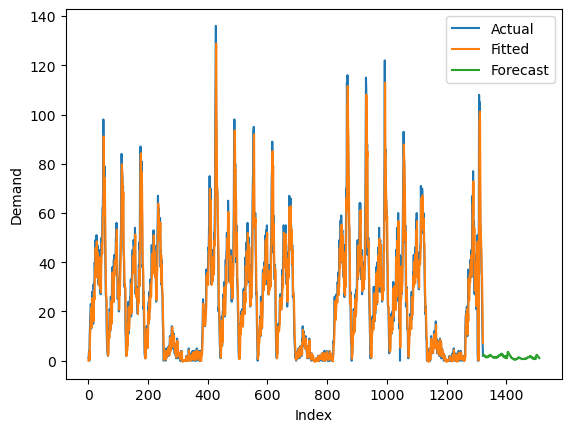

In [19]:
plt.plot(full_data.index[:len(actual_values)], actual_values, label='Actual')
plt.plot(full_data.index[:len(fitted_values)], fitted_values, label='Fitted')
plt.plot(full_data.index[len(combined_set):], forecast_values, label='Forecast')
plt.xlabel('Index')
plt.ylabel('Demand')
plt.legend()
plt.show()

---
<a id="T.9"></a>
### Additional Task: Discuss the limitations and challenges encountered during the forecasting process and propose potential strategies to overcome them.
- #### Limitations and Challenges in the Forecasting Process:

    * ##### `Insufficient or Noisy Data`: Ensure sufficient and clean data through improvements in data collection, preprocessing techniques, and data augmentation.

    * ##### `Seasonality and Trend Changes`: Account for changing patterns by using dynamic or adaptive models, periodic model retraining, or updating.

    * ##### `Overfitting or Underfitting`: Mitigate overfitting through regularization or model selection methods, and address underfitting by adjusting model orders or exploring alternative models.

    * ##### `Forecast Horizon`: Consider incorporating exogenous variables or ensemble methods for longer-term forecasts.

    * ##### `Model Selection and Hyperparameter Tuning`: Utilize systematic approaches like grid search or automated algorithms for model selection and hyperparameter tuning.

    * ##### `Uncertainty and Forecast Evaluation`: Assess uncertainty through prediction intervals or simulations, and continuously evaluate and monitor forecasts for model degradation or changes.
    * ##### `Additional features`: Getting new features for the dataset, may or surely will help in forecasting the demand accurately

---
<a id="T.10"></a>
### Additional Task: Explain how your forecasting method can be applied to other public transportation systems and the potential benefits it can provide.
- #### Applying the SARIMA forecasting method or similar techniques to other public transportation systems provides the following benefits:

   * ##### `Demand Forecasting`: Accurate predictions of future demand help optimize resource allocation, schedule services, and plan capacity.

   * ##### `Service Planning`: Forecasting assists in designing effective service plans, optimizing routes, frequencies, and vehicles deployment for improved residents experience.

   * ##### `Revenue Management`: Dynamic fare pricing based on demand forecasts maximizes revenue while ensuring affordability.

   * ##### `Resource Allocation`: Efficient allocation of resources such as vehicles and staff reduces costs and improves system performance.

   * ##### `Maintenance Planning`: Predicting maintenance requirements optimizes schedules, prevents breakdowns, and enhances system reliability.

   * ##### `Proactive Decision-Making`: Accurate forecasts enable proactive management, anticipating demand fluctuations and addressing potential bottlenecks.

#### By leveraging forecasting methods, public transportation systems can optimize operations, enhance service quality, and achieve their goals of efficiency, revenue maximization, and customer satisfaction.